## Imports and stuff

In [34]:
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout, Activation
from keras.models import Sequential
from keras.optimizers import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [35]:
X_train = np.array(np.load("X_train.npy"))
y_train = np.array(np.load("y_train.npy"))
X_dev = np.array(np.load("X_dev.npy"))
y_dev = np.array(np.load("y_dev.npy"))
X_test = np.array(np.load("X_test.npy"))
y_trainonehot = np.array(pd.get_dummies(y_train))
y_devonehot = np.array(pd.get_dummies(y_dev))

In [36]:
def score_func(y_test, y_true):
    if (len(y_test) != len(y_true)):
        raise ValueError("The two arrays aren't of the same length, aborting")
    else:
        return 100*len([y_test[i] for i in range(len(y_test)) if y_test[i]==y_true[i]])/len(y_test)

## Neural Network

In [37]:
print(X_train.shape, X_dev.shape, X_test.shape)
X_tot = np.concatenate([X_train, X_dev, X_test])
lol = PCA(n_components = 50)
X_tot = lol.fit_transform(X_tot)
X_tot = preprocessing.scale(X_tot)
X_train, X_dev, X_test = X_tot[:len(X_train)], X_tot[len(X_train):len(X_train)+len(X_dev)], X_tot[len(X_train)+len(X_dev):]
print(X_train.shape, X_dev.shape, X_test.shape)

(582, 193) (290, 193) (298, 193)
(582, 50) (290, 50) (298, 50)


In [39]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
scores = []
cv = 1
for i in range(cv):
    model = Sequential()
    model.add(Dense(20, input_dim = 50))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(Dense(15))
    model.add(Activation('softmax'))
    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    X = np.concatenate([X_train,X_dev])
    y = np.concatenate([y_trainonehot,y_devonehot])
    X,y = unison_shuffled_copies(X, y)
    
    history = model.fit(X,y, batch_size = 10, nb_epoch = 100, 
                        verbose = 0, validation_split = 0.5)
    score1 = model.evaluate(X_train,y_trainonehot,verbose=0)
    score2 = model.evaluate(X_dev,y_devonehot,verbose=0)
    print(score1[1], score2[1])
    scores.append((score1[1]+score2[1])/2)
print("Mean score:",np.mean(scores))

In [136]:
from sklearn.metrics import confusion_matrix
L = [np.argmax(x) for x in model.predict(X_dev)]
print(confusion_matrix(L,y_dev))

[[21  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0 18  0  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  1 17  0  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  0 18  0  0  0  0  1  0  0  3  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  0 20  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  1  0  0 18  0  0  1  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  1 22  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  4  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  2 14]]


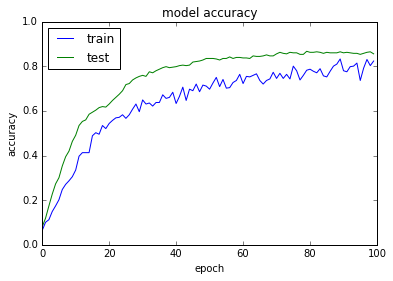

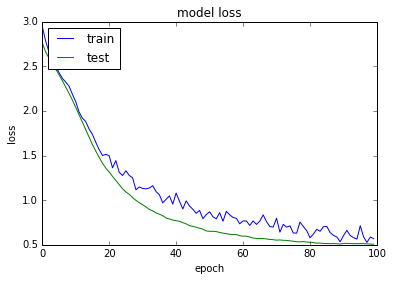

In [127]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [128]:
pred = model.predict(X_test)
pred = [np.argmax(pred[i]) for i in range(len(pred))]
np.savetxt('y_pred.txt', pred, fmt="%d")

## Regression Logistique ftw

In [8]:
clf = LogisticRegression()
clf.fit(np.concatenate([X_train,X_dev]),np.concatenate([y_train,y_dev]))
#clf.fit(X_dev, y_dev)
s = clf.predict(X_test)
np.savetxt('y_pred.txt', s, fmt="%d")